#### THIS NOTEBOOK BUILDS ON PREVIOUS WORK IN `exploring-mpii.ipynb`

In [1]:
import random
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import json
import os
import cv2
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import mixed_precision

C:\Users\willi\anaconda3\envs\tf_gpu\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
coco_folder = "coco"
image_folder_train = os.path.join(coco_folder, "images", "train2017")
image_folder_val = os.path.join(coco_folder, "images", "val2017")

In [3]:
# optional for gpus with lower vram
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [4]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Preparing the data
Compared to the MPII dataset, the COCO dataset is quite different, for many reasons. It is a large-scale object detection, segmentation, and captioning dataset. We will use it for pose estimation. The dataset also comes with its own tools, meaning we will not need to work with a painful MATLAB file like we did with the MPII dataset.

But first and foremost, let's check out how many joints are available in the annotations.


In [75]:
coco_train = json.load(open(os.path.join(coco_folder,'person_keypoints_train2017.json')))

In [77]:
i = 0
y = 0
for anno in coco_train['annotations']:
    if anno['num_keypoints'] == 17: i += 1
    if anno['num_keypoints'] == 0: y += 1

print("{} poses has all 17 joints out of {} total. There are {} poses with 0 joints.".format(i, len(coco_train['annotations']), y))

8475 poses has all 17 joints out of 262465 total. There are 112652 poses with 0 joints.


As we can see there are very few annotations with all 17 joints, meaning we can't just skip the ones that don't have all 17 joints. Another problem is the other end of the spectrum where we have over 100k poses with 0 joints, so we should skip these as well, but we should probably limit it to poses with at least 3 joints.

While we are on the topic of removing stuff, why don't we also remove joints that are not interesting to us? The COCO dataset includes 5 joints on the head: nose, left and right eye, and left and right ear. These joints are not interesting to us for this project at least, so we can skip them! (this will also free up memory and time used training the model)

### Create some JSONs
As mentioned above, COCO provides tools for its dataset, by the `pycocotools` library, so we will use this instead of doing it manually.

In [70]:
from pycocotools.coco import COCO

In [483]:
def create_json(coco_json, target_file):
    
    coco = COCO(coco_json)
    
    data = []
    
    cat_ids = coco.getCatIds(catNms=['person'])
    img_ids = coco.getImgIds(catIds=cat_ids)
    
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_name = img_info['file_name']
        
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=False)
        anns = coco.loadAnns(ann_ids)
        
        for ann in anns:
            if "keypoints" not in ann or ann["num_keypoints"] == 0:
                continue
            
            keypoints = ann["keypoints"]
            joint_coords = {}
            visible_joints = {}
            
            for i in range(5,17): # skip the first 5 joints (head joints)
                x = keypoints[i * 3]
                y = keypoints[i * 3 + 1]
                v = keypoints[i * 3 + 2]
                joint_coords[str(i - 5)] = [x, y]
                visible_joints[str(i - 5)] = str(int(v > 0))
            
            if sum(1 for v in visible_joints.values() if v == "1") < 3:
                continue
            
            data.append({
                "filename": img_name,
                "joint_coords": joint_coords,
                "visible_joints": visible_joints,
                "approx_loc": {
                    "scale": max(ann["bbox"][2], ann["bbox"][3]) / 200.0, # same as MPII
                    "x": ann["bbox"][0] + ann["bbox"][2] / 2,
                    "y": ann["bbox"][1] + ann["bbox"][3] / 2,
                }
            })
    
    with open(target_file, 'w') as f:
        json.dump(data, f, indent=2)
        print('JSON was successfully saved!')

In [485]:
create_json(
    coco_json=os.path.join(coco_folder,'person_keypoints_train2017.json'),
    target_file=os.path.join(coco_folder,'data_train.json'),
)

loading annotations into memory...
Done (t=6.88s)
creating index...
index created!
JSON was successfully saved!


In [484]:
create_json(
    coco_json=os.path.join(coco_folder,'person_keypoints_val2017.json'),
    target_file=os.path.join(coco_folder,'data_val.json'),
)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
JSON was successfully saved!


## Checkout the data
Let's show a random image and overlay the joints

In [486]:
data_train = json.load(open(os.path.join(coco_folder,'data_train.json')))

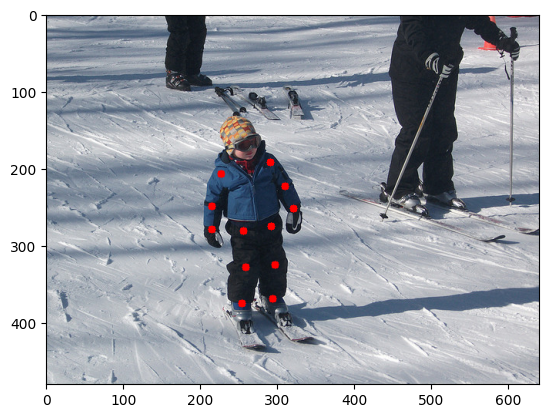

In [487]:
def plot_joints(image_path, coordinates):
    image = cv2.imread(image_path)
    for joint in coordinates:
        cv2.circle(image, (int(joint[0]), int(joint[1])), 5, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

example = data_train[13501]
img_filename = example.get('filename')
joints = example.get('joint_coords')

joint_coords = []
for joint, coords in joints.items():
    joint_coords.append((coords[0], coords[1]))

plot_joints(os.path.join(image_folder_train,img_filename), joint_coords)

## Preprocessing the data
We will have to resize and crop the images to the same size, we will also save this into a HDF5 file as it handles large amounts of data very well.

A major change we made since working on the MPII dataset are the shapes, instead of an image being 128x128, it is now 256x256. As well as this we realized that there is no real reason to have the heatmaps the same size, and after looking around the internet it was clear that heatmaps at a quarter of the image size was plenty.

For the MPII dataset we used a `generate_heatmap()` function by ChatGPT, which was ok, but since we now have 64x64 images, we need it to be more precise since we are scaling it up before training. As this kind of mathematics is very dank, we decided to ask ChatGPT this time as well (to save some precious time). We have of course changed some of the code, as ChatGPT rarely produces something that JUST works. As I am about to mention, we did some research to OpenCV and also found that `.circle()` and `.GaussianBlur()` could calculate these gaussian heatmaps, but it is not as accurate as making a custom one.

We also made a custom function for padding the image if needed, but after researching OpenCV further we found `cv2.copyMakeBorder()` which does this for us, so we will just use this instead.

In [488]:
data_train = json.load(open(os.path.join(coco_folder,'data_train.json')))
data_val = json.load(open(os.path.join(coco_folder,'data_val.json')))

In [507]:
def preprocess_image(img_path, objpos, scale, img_size=(256, 256)):
    img = cv2.imread(img_path)
    h, w, _ = img.shape

    crop_size = int(scale * 200)
    x1, y1 = int(objpos[0] - crop_size // 2), int(objpos[1] - crop_size // 2)
    x2, y2 = x1 + crop_size, y1 + crop_size

    pad_top = max(0, -y1)
    pad_left = max(0, -x1)
    pad_bottom = max(0, y2 - h)
    pad_right = max(0, x2 - w)

    # apply padding if needed
    img_padded = cv2.copyMakeBorder(
        img,
        pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0]
    )

    x1 += pad_left
    y1 += pad_top
    x2 += pad_left
    y2 += pad_top

    cropped_img = img_padded[y1:y2, x1:x2]
    resized_img = cv2.resize(cropped_img, img_size)

    scale_factor = img_size[0] / crop_size
    transform_params = (x1, y1, scale_factor)

    return resized_img, transform_params

def adjust_keypoints(keypoints, transform_params):
    x1, y1, scale_factor = transform_params
    adjusted_keypoints = np.zeros((12,2), dtype=np.float32)
    
    for key, (x, y) in keypoints.items():
        if x == 0 and y == 0: 
            # keep invisible joints at 0,0
            adjusted_keypoints[int(key)] = [0,0]
            continue
        x_new = (x - x1) * scale_factor
        y_new = (y - y1) * scale_factor
        adjusted_keypoints[int(key)] = [x_new, y_new]
    
    return adjusted_keypoints

def generate_heatmap(joint_coords, visible_joints, image_size=(256,256), heatmap_size=(64, 64), sigma=2): # Inspiration from ChatGPT
    num_joints = len(joint_coords)
    heatmaps = np.zeros((heatmap_size[1], heatmap_size[0], num_joints), dtype=np.float32)
    tmp_size = sigma * 3

    for j in range(num_joints):
        if str(j) not in visible_joints or int(visible_joints[str(j)]) == 0: continue

        # Original image coords
        x, y = joint_coords[j]
        if x < 0 or y < 0:
            continue

        # Scale to heatmap size
        x = x * heatmap_size[0] / image_size[0]
        y = y * heatmap_size[1] / image_size[1]

        # Gaussian bounds
        ul = [int(x - tmp_size), int(y - tmp_size)]
        br = [int(x + tmp_size + 1), int(y + tmp_size + 1)]

        # Skip if it's out of bounds
        if ul[0] >= heatmap_size[0] or ul[1] >= heatmap_size[1] or br[0] < 0 or br[1] < 0:
            continue

        # Generate Gaussian
        size = 2 * tmp_size + 1
        g = np.exp(-((np.arange(size)[:, None] - tmp_size) ** 2 + (np.arange(size)[None, :] - tmp_size) ** 2) / (2 * sigma ** 2))

        # Determine where to place the Gaussian
        g_x = max(0, -ul[0]), min(br[0], heatmap_size[0]) - ul[0]
        g_y = max(0, -ul[1]), min(br[1], heatmap_size[1]) - ul[1]
        img_x = max(0, ul[0]), min(br[0], heatmap_size[0])
        img_y = max(0, ul[1]), min(br[1], heatmap_size[1])

        heatmaps[img_y[0]:img_y[1], img_x[0]:img_x[1], j] = np.maximum(
            heatmaps[img_y[0]:img_y[1], img_x[0]:img_x[1], j],
            g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
        )

    return heatmaps

### Test the functions
Let's test out the functions by plotting the outputs over the original image 

In [517]:
def overlay_heatmaps_and_joints(image, joints, visible_joints, alpha=0.4, sigma=2):
    image_size = (image.shape[0], image.shape[1])
    heatmap_size = (image.shape[1] // 4, image.shape[0] // 4)
    
    heatmaps = generate_heatmap(joints, visible_joints, image_size, heatmap_size, sigma)
    
    heatmaps_resized = np.zeros((image.shape[0], image.shape[1], heatmaps.shape[-1]), dtype=np.float32)
    for i in range(heatmaps.shape[-1]):
        heatmaps_resized[:, :, i] = cv2.resize(heatmaps[:, :, i], (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
    
    combined_heatmap = np.sum(heatmaps_resized, axis=-1)
    combined_heatmap = np.clip(combined_heatmap, 0, 1) # some heatmaps might overlay each other and cause the sum to be higher than 1
    
    plt.figure(figsize=(6, 6))
    for joint in joints:
        cv2.circle(image, (int(joint[0]), int(joint[1])), 3, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(combined_heatmap, cmap="jet", alpha=alpha)
    plt.axis('off')
    plt.show()

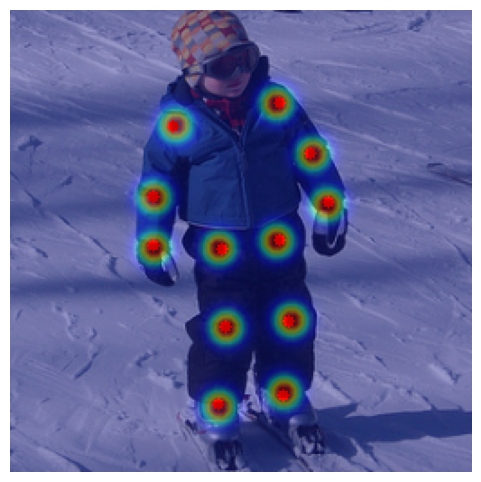

In [518]:
ann = data_train[13501]

preprocessed_img, transform_params = preprocess_image(
    os.path.join(image_folder_train, ann['filename']), 
    (ann['approx_loc']['x'], ann['approx_loc']['y']), 
    ann['approx_loc']['scale'])

joint_coords = ann['joint_coords']
visible_joints = ann['visible_joints']
adjusted_joints = adjust_keypoints(joint_coords, transform_params)

overlay_heatmaps_and_joints(preprocessed_img, adjusted_joints, visible_joints, sigma=1.5)

## Create and save some datasets
Seeing that the functions are working, we can now put this all in a dataset file.

In [519]:
def create_dataset(dataset, name, image_folder):
    num_samples = len(dataset)
    
    with h5py.File(os.path.join(coco_folder,name + '.h5'), 'w') as f:
        img_dataset = f.create_dataset("images", (num_samples, 256, 256, 3), dtype='uint8')
        heatmaps_dataset = f.create_dataset("heatmaps", (num_samples, 64, 64, 12), dtype='uint8')
        
        index = 0
        for ann in dataset:
            img_path = os.path.join(image_folder, ann['filename'])
            objpos = (ann['approx_loc']['x'], ann['approx_loc']['y'])
            scale = ann['approx_loc']['scale']
            
            preprocessed_img, transform_params = preprocess_image(img_path, objpos, scale)
            img_dataset[index] = preprocessed_img
            
            adjusted_keypoints = adjust_keypoints(ann['joint_coords'], transform_params) / 256.0 # normalize the values
            visible_joints = ann['visible_joints']
            heatmaps_dataset[index] = (generate_heatmap(adjusted_keypoints, visible_joints, (256, 256), (64, 64), sigma=1.5) * 255).astype(np.uint8) # scale to 0-255
            
            index += 1
    
    print(name + ".h5 successfully created")

create_dataset(data_train, 'train_dataset', image_folder_train)
create_dataset(data_val, 'val_dataset', image_folder_val)

train_dataset.h5 successfully created
val_dataset.h5 successfully created


## Building a model
Let's load the dataset first

In [ ]:
with h5py.File(os.path.join(coco_folder, 'train_dataset.h5'), 'r') as f:
    d_images = np.array(f['images'], dtype=np.float16) / 255.0 # normalize the images to [0,1]
    d_heatmaps = np.array(f['heatmaps'], dtype=np.float16) / 255.0 # normalize the heatmaps to [0,1]
    num_samples = d_images.shape[0]

### Loading the dataset file
If you have enough memory you can directly load the dataset, try the code in the cell below, but if it fails, we will need to load the data from the file using a generator

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((d_images, d_heatmaps)).batch(16).prefetch(tf.data.AUTOTUNE)

If the cell above throws an error, we will need to use the generator below:

In [8]:
def data_generator():
    for i in range(num_samples):
        yield d_images[i], d_heatmaps[i]

dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float16),
        tf.TensorSpec(shape=(128, 128, 16), dtype=tf.float16),
    )
)

### Splitting into training and validation datasets
We now need to split the dataset into two datasets at an 80/20 split. An important part of this is that we have to make sure that we split the dataset before taking out batches and shuffling the dataset, as `.take()` and `.skip()` will not work properly unless we do this.

In [9]:
train_ratio = 0.8
train_size = int(num_samples * train_ratio)

train_data = dataset.take(train_size).shuffle(num_samples, seed=42).batch(16).prefetch(tf.data.AUTOTUNE)
val_data = dataset.skip(train_size).batch(16).prefetch(tf.data.AUTOTUNE)
print(f"Train samples: {train_size}, Validation samples: {num_samples - train_size}")

Train samples: 15935, Validation samples: 3984


### A more complicated model
The model below will predict a heatmap for every joint

In [7]:
def basic_block(input_tensor, filters, strides=1, dilation_rate=2):
    shortcut = input_tensor
    x = layers.Conv2D(filters, (3,3), strides=strides, padding='same', use_bias=False, dilation_rate=dilation_rate)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3,3), padding='same', use_bias=False, dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1,1), strides=strides, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    out = layers.ReLU()(x)
    return out

def make_layer(x, block, filters, blocks):
    for _ in range(blocks):
        x = block(x, filters)
    return x

def build_heatmap_model(input_shape=(128,128,3), num_joints=16):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (3,3), strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x1 = make_layer(x, basic_block, 64, 4)
    x2 = make_layer(x1, basic_block, 128, 2)
    x3 = make_layer(x2, basic_block, 256, 2)
    
    # x2_up = layers.Conv2DTranspose(128, (1,1), padding='same')(x3)
    # x2_up = layers.UpSampling2D(2)(x2_up)
    # x2_concat = layers.Concatenate()([x2_up, x2])
    # 
    # x1_up = layers.Conv2DTranspose(64, (1,1), padding='same')(x2_concat)
    # x1_up = layers.UpSampling2D(2)(x1_up)
    # x1_concat = layers.Concatenate()([x1_up, x1])
    
    output = layers.Conv2D(num_joints, (1,1), padding='same', activation="sigmoid")(x3)
    return keras.Model(inputs, output, name="Heatmap_Detection")

### A Stacked Hourglass Network model
Stacked hourglass networks has proven to be effective for human pose estimation. This architecture has given state-of-the-art results on the MPII dataset and has outcompeted all recent methods.

https://paperswithcode.com/paper/stacked-hourglass-networks-for-human-pose

It is based on this model: https://github.com/ethanyanjiali/deep-vision/blob/master/Hourglass/tensorflow/hourglass104.py

In [35]:
def bottleneck_block(x, filters, downsample=False):
    skip = x
    if downsample:
        skip = layers.Conv2D(filters, (1,1), strides=1, padding='same', kernel_initializer='he_normal')(skip)
    
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters // 2, (1,1), strides=1, padding='same', kernel_initializer='he_normal')(x)
    
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters // 2, (3,3), strides=1, padding='same', kernel_initializer='he_normal')(x)
    
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (1,1), strides=1, padding='same', kernel_initializer='he_normal')(x)
    
    x = layers.Add()([x, skip])
    return x

def hourglass_module(x, filters, depth):
    up = bottleneck_block(x, filters)
    up = bottleneck_block(up, filters)
    
    low = layers.MaxPooling2D((2,2), strides=2)(x)
    low = bottleneck_block(low, filters)
    
    if depth > 1:
        low = hourglass_module(low, filters, depth - 1)
    else:
        low = bottleneck_block(low, filters)
    
    low = bottleneck_block(low, filters)
    up2 = layers.UpSampling2D((2,2))(low)
    
    return up + up2

def build_stacked_hourglass(input_shape=(128,128,3), num_joints=16, stack=4):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (7,7), strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = bottleneck_block(x, 128, downsample=True)
    x = layers.MaxPooling2D((2,2), strides=2)(x)
    x = bottleneck_block(x, 128, downsample=False)
    x = bottleneck_block(x, 256, downsample=True)
    
    outputs = []
    for i in range(stack):
        hg = hourglass_module(x, 256, depth=4)
        hg = bottleneck_block(hg, 256)
        
        hg = layers.Conv2D(256, (1,1), strides=1, padding='same', kernel_initializer='he_normal')(hg)
        hg = layers.BatchNormalization(momentum=0.9)(hg)
        hg = layers.ReLU()(hg)
        
        if hg.shape[1] == 32: hg = layers.UpSampling2D(size=(4,4), interpolation="bilinear")(hg)  # Upsample from 32x32 to 128x128
        out = layers.Conv2D(num_joints, (1,1), strides=1, padding='same', kernel_initializer='he_normal')(hg)
        outputs.append(out)
        
        # adding the prediction back for next module
        x = layers.Conv2D(256, (1,1), strides=1)(hg)
        x = layers.Conv2D(256, (1,1), strides=1)(out)
        x = layers.Add()([x, hg])
    
    return keras.Model(inputs, outputs, name="StackedHourglass_Detection")

### Create a model with a pretrained model
Let's try out the MobileNetV2 model as the backbone of our model

https://keras.io/examples/vision/keypoint_detection/

In [156]:
def build_pretrained_model(input_shape=(128,128,3), num_joints=16):
    inputs = layers.Input(shape=input_shape)
    
    base_model = keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs,
        pooling=None,
    )
    
    x = base_model.output # Shape will be (4,4,1280) for 128x128
    
    x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    
    outputs = layers.Conv2D(num_joints, (1,1), padding='same', activation="relu")(x)  # (128,128,16)
    
    return keras.Model(base_model.input, outputs, name="ResNet50-Base_Detection")

### Compile and fit
An important part about training is the hyperparameters, and some of the most important ones are optimization algorithm, learning rate, loss function, and epochs.

In [36]:
model = build_stacked_hourglass()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
    loss='mse',
)

model.summary()

Model: "StackedHourglass_Detection"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1682 (Conv2D)           (None, 64, 64, 64)   9472        ['input_12[0][0]']               
                                                                                                  
 batch_normalization_1588 (Batc  (None, 64, 64, 64)  256         ['conv2d_1682[0][0]']            
 hNormalization)                                                                                  
                                                                         

In [37]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint("best-resnet-model_before-data-aug.h5", monitor="val_loss", save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ]
)

      3/Unknown - 2268s 743s/step - loss: nan - conv2d_1749_loss: nan - conv2d_1807_loss: nan - conv2d_1865_loss: nan - conv2d_1923_loss: nan

KeyboardInterrupt: 

In [78]:
# We should always save our model
model.save('model_heatmap_resnet50_lr1e3-mse-mae_e10-train-val-early-reducelr.keras')
np.save('history-resnet.npy', history)

INFO:tensorflow:Assets written to: ram://78eb8222-d8c5-4a65-8f3f-456945eb9612/assets


INFO:tensorflow:Assets written to: ram://78eb8222-d8c5-4a65-8f3f-456945eb9612/assets


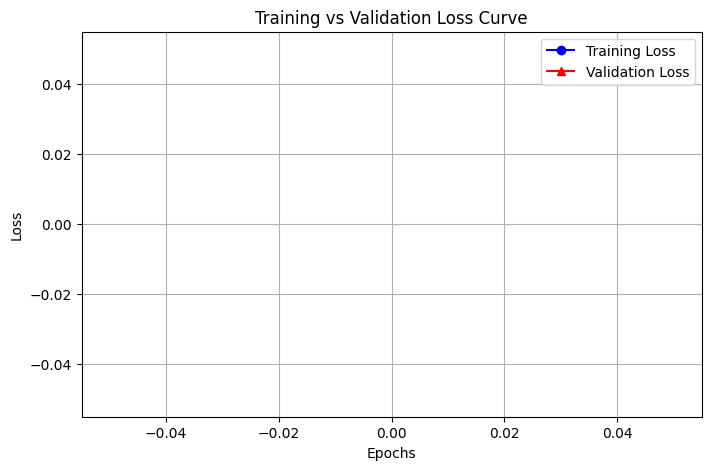

In [143]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # 'bo-' makes blue dots & line
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')  # 'r^-' makes red triangles & line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

## Let's test the model
We will now use the model to predict heatmaps from a random test image, but before then we need to preprocess the test image as well

In [1]:
# Optional, load the model from storage
model = keras.models.load_model('model_heatmap_data-aug.keras')

NameError: name 'keras' is not defined

In [12]:
data = json.load(open(os.path.join(mpii_folder,'data.json')))
joints_list = json.load(open(os.path.join(mpii_folder,'joints.json')))

In [170]:
testdata = []
for ann in data:
    if ann['for_training'] == 0:
        testdata.append(ann)

color_map = ['#ff9e9e','#ff6161','#ff0000','#ffb700','#ffcf54','#ffe49e','#000','#9000ff','#c06eff','#e2bdff','#b3ffd9','#5effaf','#00ff1e','#0015ff','#4252ff','#808aff']

def preprocess_test_image(test_image):
    image, _ = preprocess_image(
        os.path.join(image_folder, test_image['filename']), 
        (test_image['approx_loc']['x'], test_image['approx_loc']['y']), 
        test_image['approx_loc']['scale']
    )
    
    image = image / 255.0
    return image

def extract_joints(heatmaps):
    coords = []
    for i in range(heatmaps.shape[-1]):
        heatmap = heatmaps[..., i]
        heatmap = tf.nn.softmax(tf.reshape(heatmap, [-1]))
        idx = tf.argmax(heatmap, axis=0)
        y, x = tf.unravel_index(idx, (heatmaps.shape[0], heatmaps.shape[1]))
        coords.append([x.numpy(), y.numpy()])
    return np.array(coords)

def extract_and_plot_joints(image, heatmaps):
    extracted_joints = extract_joints(heatmaps)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB))
    # plt.imshow(np.sum(heatmaps, axis=-1), cmap="jet", alpha=0.4)
    
    for i, (x, y) in enumerate(extracted_joints):
        plt.scatter(x, y, c=color_map[i], s=20, marker='o', label=joints_list[str(i)])
    
    plt.legend(bbox_to_anchor=(1,1))
    plt.axis("off")
    plt.show()

def plot_heatmaps(image, heatmaps):
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB))
        ax.imshow(heatmaps[:, :, i], cmap='jet', alpha=0.6)
        ax.set_title(joints_list[str(i)])
        ax.axis('off')
    
    plt.show()

In [3]:
# test_image = testdata[3700]
# input_image = preprocess_test_image(test_image)
input_image = cv2.imread(os.path.join(dataset_folder, 'cyclist-3.jpg')) / 255.0
predictions = model.predict(np.expand_dims(input_image, axis=0))

NameError: name 'cv2' is not defined

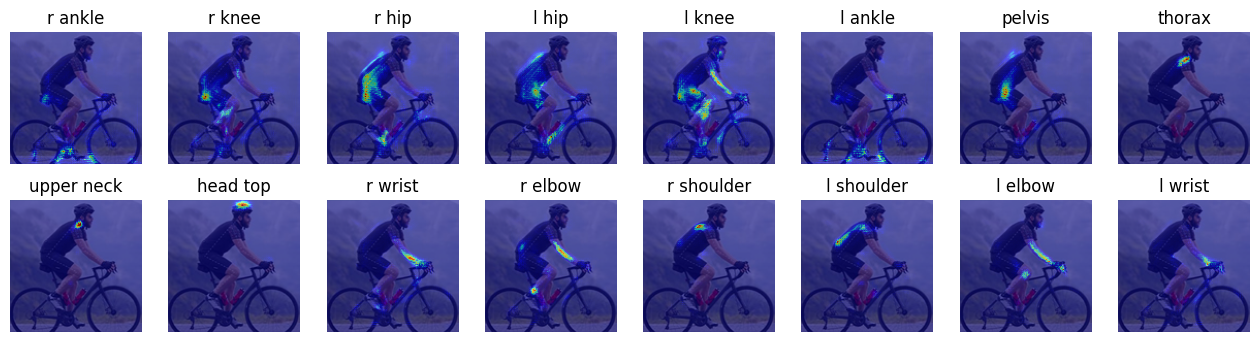

In [209]:
heatmaps = tf.squeeze(predictions)

plot_heatmaps(input_image, heatmaps)

## Extract joints
Above we have the predictions the model made based on each joint, lets now try to extract a joint from each heatmap

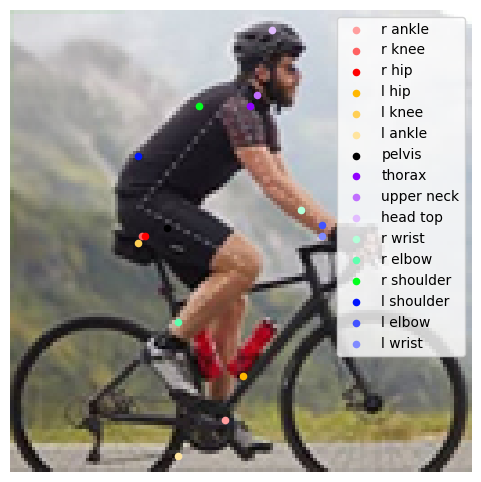

In [194]:
extract_and_plot_joints(input_image, heatmaps)

## Data Augmentation
Normally we could do this with Keras augmentation layers, but these are designed only for images - they don't handle our joints. Because of this we will need to do this manually. OpenCV, which we have used before, comes with a some neat functions for handling the images; `getRotationMatrix2D()` and `warpAffine()`, and `transform()` for the other properties.

We will also need to put this into a .h5 file like previously with the full training data.

In [12]:
cyclist_data = []
for ann in data:
    if ann['for_training'] == 0: continue
    if 'bicycling' in ann['category']: cyclist_data.append(ann)

In [278]:
def affine_transform(image, joints, angle=0, scale=1.0, translation=(0, 0)):
    h,w = image.shape[:2]
    
    center = (w / 2, h / 2)
    matrix = cv2.getRotationMatrix2D(center, angle, scale)
    matrix[:, 2] += translation
    
    t_image = cv2.warpAffine(image, matrix, (w, h))
    
    pre_joints = np.hstack([joints, np.ones((joints.shape[0], 1))])
    t_joints = np.dot(matrix, pre_joints.T).T
    
    return t_image, t_joints

def augment_image(image, joints, prob=0.5):
    h,w = image.shape[:2]
    
    angle = random.uniform(-15, 15)

    image, joints = affine_transform(image, joints, angle, 1.0, (0,0))
    
    image = cv2.convertScaleAbs(
        image, 
        alpha=1.0 + random.uniform(-0.1, 0.1),
        beta=random.uniform(-0.2, 0.4) * 255,
    )
    
    if random.random() < prob:
        image = cv2.flip(image, 1) # flip horizontally
        joints[:, 0] = w - joints[:, 0] # flip x-coordinates
    
    return image, joints

def create_cyclist_dataset(dataset, name, augmentations_per_image=5):
    num_samples = len(dataset) * augmentations_per_image
    
    with h5py.File(os.path.join(mpii_folder,name + '.h5'), 'w') as f:
        img_dataset = f.create_dataset("images", (num_samples, 128, 128, 3), dtype='uint8') # IMG SIZE (128,128,3)
        heatmaps_dataset = f.create_dataset("heatmaps", (num_samples, 128, 128, 16), dtype='uint8') # IMG SIZE + joints
        
        index = 0
        for ann in dataset:
            img_path = os.path.join(image_folder, ann['filename'])
            objpos = (ann['approx_loc']['x'], ann['approx_loc']['y'])
            scale = ann['approx_loc']['scale']
            
            preprocessed_img, transform_params = preprocess_image(img_path, objpos, scale)
            adjusted_keypoints = adjust_keypoints(ann['joint_coords'], transform_params)
            
            for _ in range(augmentations_per_image):
                aug_image, aug_joints = augment_image(preprocessed_img, adjusted_keypoints)
                
                img_dataset[index] = aug_image
                heatmaps_dataset[index] = (generate_heatmap((128, 128), aug_joints / 128) * 255).astype(np.uint8) # scale to 0-255
                
                index += 1
            
            if index >= num_samples: break
    
    print(name + ".h5 successfully created")

create_cyclist_dataset(cyclist_data, 'cyclist_dataset', augmentations_per_image=7)

cyclist_dataset.h5 successfully created


### Loading the dataset
We repeat the process like before with loading the dataset and creating a TensorFlow dataset from it.

In [18]:
with h5py.File(os.path.join(mpii_folder, 'cyclist_dataset.h5'), 'r') as f:
    cd_images = np.array(f['images'], dtype=np.float16) / 255.0 # normalize the images to [0,1]
    cd_heatmaps = np.array(f['heatmaps'], dtype=np.float16) / 255.0 # normalize the heatmaps to [0,1]
    num_samples_cycling = cd_images.shape[0]

either like this:

In [ ]:
cyclist_dataset = tf.data.Dataset.from_tensor_slices((cd_images, cd_heatmaps))

or like this:

In [19]:
def data_generator():
    for i in range(num_samples_cycling):
        yield cd_images[i], cd_heatmaps[i]

cyclist_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float16),
        tf.TensorSpec(shape=(128, 128, 16), dtype=tf.float16),
    )
)

In [20]:
train_ratio = 0.8
train_size = int(num_samples_cycling * train_ratio)

cyclist_train_data = cyclist_dataset.take(train_size).shuffle(num_samples, seed=42).batch(16).prefetch(tf.data.AUTOTUNE)
cyclist_val_data = cyclist_dataset.skip(train_size).batch(16).prefetch(tf.data.AUTOTUNE)
print(f"Train samples: {train_size}, Validation samples: {num_samples_cycling - train_size}")

Train samples: 3959, Validation samples: 990


In [79]:
model = keras.models.load_model('model_heatmap_t1_lr1e4-huber-mae_e100-train-val-early-reducelr.keras')

retrained_history = model.fit(
    cyclist_train_data,
    validation_data=cyclist_val_data,
    epochs=100,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint("best_heatmap_model.h5", monitor="val_loss", save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ]
)

Epoch 1/100
248/248 [==============================] - 99s 393ms/step - loss: 3.6721e-04 - mae: 0.0024 - val_loss: 3.6910e-04 - val_mae: 0.0025 - lr: 1.0000e-06
Epoch 2/100
248/248 [==============================] - 97s 392ms/step - loss: 3.6631e-04 - mae: 0.0026 - val_loss: 3.6854e-04 - val_mae: 0.0026 - lr: 1.0000e-06
Epoch 3/100
248/248 [==============================] - 97s 392ms/step - loss: 3.6574e-04 - mae: 0.0026 - val_loss: 3.6819e-04 - val_mae: 0.0027 - lr: 1.0000e-06
Epoch 4/100
248/248 [==============================] - 97s 392ms/step - loss: 3.6528e-04 - mae: 0.0027 - val_loss: 3.6786e-04 - val_mae: 0.0027 - lr: 1.0000e-06
Epoch 5/100
248/248 [==============================] - 97s 391ms/step - loss: 3.6494e-04 - mae: 0.0027 - val_loss: 3.6767e-04 - val_mae: 0.0028 - lr: 1.0000e-06
Epoch 6/100
248/248 [==============================] - 97s 392ms/step - loss: 3.6475e-04 - mae: 0.0028 - val_loss: 3.6754e-04 - val_mae: 0.0028 - lr: 1.0000e-06
Epoch 7/100
248/248 [=============

KeyboardInterrupt: 

In [22]:
model.save('model_heatmap_data-aug_e100-early-reducelr.keras')
np.save('retrained_history.npy', retrained_history)